In [3]:
import warnings
warnings.filterwarnings("ignore") # suppress h5py deprecation warning

import pandas as pd
import numpy as np
import time
import datetime
import os

from btgym.research.model_based.model.bivariate import BPM

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
plt.rcParams["font.size"] = "12"
plt.style.use('seaborn-white')

_Related BTGym submodules:_

     btgym.research.model_based.model 

-------


### 1 Introducing analytic data model

To successfully train an agent with limited amount of historic data, environment model is required. As broker dynamics are known and deterministic (well, for now we assume it so), problem reduces to modelling price dynamics.

For this example we leave modern state-of-the-art deep generative probabilistic models to future work and restrict ourselves to “immortal classic” of stochastic autoregressive models, widely used in econometrics and statistics. In particular, we model price data as AR(1) processes with some fancy engineering. Advantages is that we have analytic solutions, model is extremely computationally cheap, allows simple visual interpretation and helps build general intuition.

-------

### 2 Informal model design overview
 
_We make a basic assumption that price we observe is a realisation of some stochastic process._ 
If able to recover process properties, we can generate infinite number of trajectories which are statistically equivalent to one we observe.  

We constrain ourselves to well known setup of pair statistical arbitrage spread trading. An agent is operating on two asset prices  and only allowed to open a balanced “spread position”: short one asset and long other and vice versa.

Established approach is to model spread price movement as Ornshtein-Uhlenbeck process. To capture realistic heavy-tailed distributions of returns (such as price jumps) we’ll use t-Student distributed innovations instead of gaussian ones.

Distinguishing  feature of presented model is that we are interested in building joint model of two assets. That is, we want build _single_ model that captures properties of _pair_ of time series.

To do so, we first transform two original time-series into P(rice) factor and S(pread) factor. Let P-factor be a mean of and S-factor be a difference of normalised original time series (actually, as zero-step transform we need to put price data into log-space to ensure positive generated values lately, but that is technical step).

One can easily see that  P captures common stochastic (non-stationary) trend of data and S captures spread of the data. This is due to facts that we apply mean and difference to already _normalized_ data and cointegration relation can be viewed as relation of data volatilities (strictly, we should talk about relation of volatilities of stochastic trends of datas, but for empirical price data sets those are numerically almost indistinguishable). 

Modelling S-factor as Ornshtein-Uhlenbeck process is a natural choice since it is stationary and mean-reverting. P-factor, as most volatile and non-stationary component, should be modelled as Weiner (or, broadly, Levy) process. But in practice it can be as well approximated by same t-driven OU process (in this case mean-reverting speed just goes to zero and whole AR(1) model became near-unit-root one) with some care taken of numerical stability.

Another notion is that P- and S-processes innovations are correlated in practice. By capturing that correlation one can can see two OU processes as a single bivariate one.

With these conceptions in hand, we aim to build state-space model that, at any given discrete time moment, infer properties of our paired assets (captured in exponentially decaying sliding time window) as point in model space. Doing it sequentially we draw trajectory in state space, capturing system evolution. 

What are benefits of applying such ‘analytic encoder’? 
Low-dimensional  state space captures statistical properties of data that are crucial to our final objective (trade decision making). Every OU process is fully characterized by (mu, theta, sigma) - mean, mean-reverting parameter and dispersion parameter. So we have six essence parameters describing our pair (and only three are directly relevant to decision making as 'spread trading' simply means we ‘trade’ S-factor only, filtering P out). Yes, it is also a t-drivers shapes (two degrees-of-freedom params) and P|S-innovation correlation. Not to forget normalisation statistics for every asset. But in an essence, it is only three key parameters for each factor. 

It is important that we see those key parameters as gaussian random variables. Usually casting observations to latent r.v. is done via Kalman filtering, but here a simpler approach is applied: we make our latent points gaussian r.v. with mean equal to observation and covariance estimated straight from variability of data itself in exponentially decaying moving time window.

Now generative part (decoder).
As we’ve got analytic formulae for OU process, we can randomly sample a point in a state space, generate infinite number of arbitrary length realisation P- and S-trajectories, apply all inverse transformations and get synthetic asset prices with desired statistical properties.

To sum up, he have fast and simple generative model. One can think of it as of ‘steam variational autoencoder’. 

------

###### Notes: 

1. To be strictly compatible with state-space model definitions, we should sample a trajectory in state space, not a single point, but we leave it to future work.

2. Btw, due to existense of analytic solutions our steampunk model does not makes and VAE-like assumption that gaussian distribution of latent variables is isotropic :)

3. Defining spread as most stationary component is not always optimal from practical side: it can be profitable to ‘adjust’  cointegration relation resulting in less faster reverting (‘less stationary’) but more volatile spread. This is known as ‘spread construction’ and can be done with variety of criteria, e.g. search for ‘variance threshold statistical arbitrage’. Incorporating it in RL setup is promising future direction.

-------

###### Sources and related literature

Short and concise introduction to OU processes applications in statistical arbitrage and, especially, view of cointegration as model-free concept is found in [1], §3, 4. Connections of orthogonal time-series decomposition and cointegration are also drawn in [6]. Simple and illuminating view on cointegration coefficient as relation of volatilities attributed to common stochastic trend can be found in [3], §3.6, Prop.2. Construction of a spread with desired properties is discussed in [2], [4], [5]. General analytical approach to optimal mean-reverting trading problem derived in [7]. Two-factor model approach is inspired by [8].  Reviews of non-gaussian OU processes and its applications are [9], [10] and [11, in Russian]. Recursive methods for exponentially smoothed mean, variance and covariance estimation are derived from [12].

-------

[1] Attilio Meucci, “Review of Statistical Arbitrage, Cointegration, and Multivariate Ornstein-Uhlenbeck”, 2010

[2] Richard Diamond, “Learning and Trusting Cointegration in Statistical Arbitrage”, 2013

[3] Dimitrios D. Thomakos, “Optimal Linear Filtering, Smoothing and Trend Extraction for Processes with Unit Roots and Cointegration”, 2008

[4]  Marco Cuturi,  Alexandre d'Aspremont, “Mean-Reverting Portfolios: Tradeos Between Sparsity and Volatility”, 2015

[5]  Marco Cuturi,  Alexandre d'Aspremont, “Mean Reversion with a Variance Threshold”

[6] David Harris, “Principal Component Analysis of Cointegrated Time Series”, 1997

[7] Tim Leung, Xin Li, “Optimal Mean Reversion Trading: Mathematical Analysis and Practical Applications”, 2016

[8] Eduardo Schwartz, James E. Smith, “Short-Term Variations and Long-Term Dynamics in Commodity Prices”, 2000

[9] Ole E. Barndorff-Nielsen, Neil Shephard, “Non-Gaussian OU based models and some of their uses in financial economics”, 2001

[10] N. Cufaro Petroni et al., “Stationary distributions of non Gaussian Ornstein-Uhlenbeck processes for beam halos”, 2007

[11] A. V. Chertok et al., “Regime Switching Detection For The Levy Driven Ornstein–uhlenbeck Process Using Cusum Methods”, 2016

[12] Tony Finch, “Incremental calculation of weighted mean and variance”, 2009

-------

### 3 Data
Let's jointly model short set of hourly data for USD/Bitcoin and USD/Etherium spot exchange rates.

Note that rates are evidently correlated but differ significantly in absolute values and volatility.

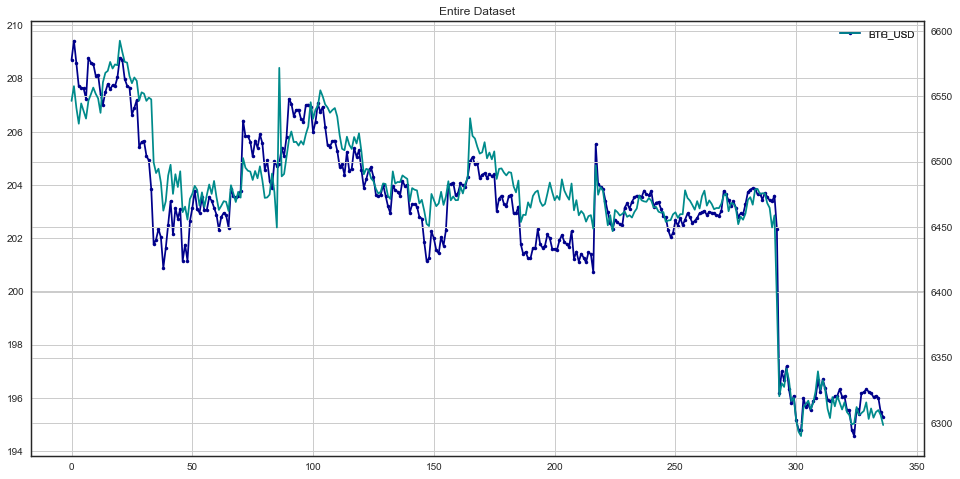

In [66]:
# Import and visualize data:

filename1 = './data/ETH_USD_hour_data.csv'
filename2 = './data/BTC_USD_hour_data.csv'

asset1 = pd.read_csv(filename1) 
asset2 = pd.read_csv(filename2) 

full_slice = slice(None, None)

fig = plt.figure(num=0, figsize=(16, 8))
plt.title('Entire Dataset')
ax1 = fig.add_subplot(111)
ax1.plot(asset1['open'][full_slice], marker='.', color='darkblue', label='ETH_USD')
ax2 = ax1.twinx()
ax2.plot(asset2['open'][full_slice],  color='darkcyan', label='BTC_USD')
_= ax1.legend()
_= ax2.legend()
ax2.grid(True)
ax1.grid(True)

# Form a pair:
pair_data = np.stack([asset1['open'][full_slice], asset2['open'][full_slice]], axis=0)

### 4 Fit model.
Note that at any moment full model state is capturred by `BivariateTSModelState` object and can be retrieved by calling `.get_state()` method.

In [73]:
# Model hyperparameters:

alpha = [.001, .001]
stat_alpha = .0001
filter_alpha = .05
ps_alpha = .05
max_length = 350

init_len = 150
stride = 1

model = BPM(
    max_length=max_length,
    alpha=alpha, 
    stat_alpha=stat_alpha,
    filter_alpha=filter_alpha,
    ps_alpha=ps_alpha,
)

# Initialise:
model.reset(pair_data[:, :init_len])

# Sequentially fit model:
state_trajectory = []  # model states
start = time.time()

for i in range(init_len, pair_data.shape[1], stride):
    x_upd = pair_data[:, i: i + stride]
    model.update(x_upd)
    #_ = model.p.process.fit_driver()  # this ones are expensive and slow, TODO: make it incremental
    #_ = model.s.process.fit_driver()  #
    
    s = model.get_state()
    state_trajectory.append(s)
    
finish = time.time()

print('Elapsed time: {:.4f} sec.'.format(finish - start))
print('State trajectory length: ', len(state_trajectory))

Elapsed time: 0.4806 sec.
State trajectory length:  187


------

##### OU t-driver fitting note
Here, t-driver fitting is disabled by default (assuming it is gaussian innovations to OU proceses). This is due to fact that it is not well optimised and most computationally expensive part of the model. Currently it is implemented via scipy.optimise Nelder-Mead optimisation, which is a batch algorithm. If anyone is aware of recursive implementation suited for online tracking - pls. let me know.

------

### 5 State-space trajectory visualisation
Here we render estimated state-space trajectory. Dropping Ou process `mu` parameter as less informative one can do it in 2D, separately for S- and P-factor (could be easily done in 3D as well). 

Along with observation trajectories we present both isotropic gausssian samples of latent variables (light blue) and full covarince samples (dark blue). Not surprisingly, full covariance sampling better follows observation trajectory than isotropic one, especially when trajectory swings.

Even with small given dataset, relative positions give clear sight that P-factor process has lower fitted mean-reverting speed `theta` parameter, approaching unit-root process.

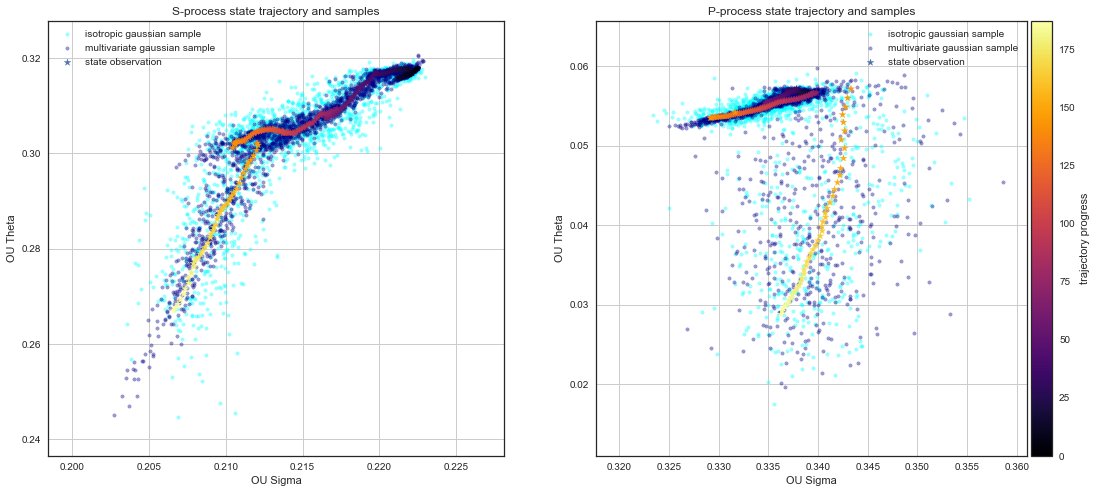

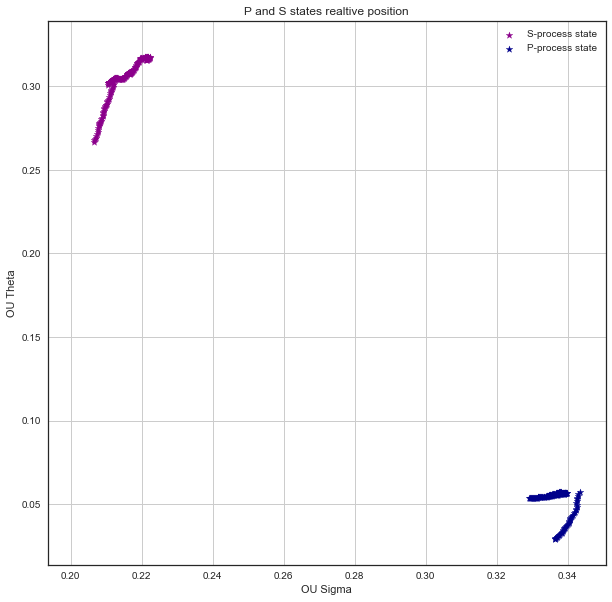

In [74]:
# State Visualization:

def nested_dict_as_array(obj):
    """Converts elements of nested dictionary to arrays"""
    if isinstance(obj, dict):
        return {key: nested_dict_as_array(value) for key, value in obj.items()}
    else:
        return np.asarray(obj)
    
def sample_process_state(zf, size=10):
    """Samples model states given states trajectory"""
    # Multivariare gaussian:
    r_sample = []
    #Isotropic gaussian:
    iso_cov = np.zeros(zf['f_cov'].shape)
    iso_cov[:,[0,1,2],[0,1,2]] = zf['f_cov'][:,[0,1,2],[0,1,2]]
    iso_r_sample = []

    naive_mean = zf['obs'] 

    for i in range(zf['f_mean'].shape[0]):
        r_sample.append(np.random.multivariate_normal(naive_mean[i, :], zf['f_cov'][i, :, :], size=size))
        iso_r_sample.append(np.random.multivariate_normal(naive_mean[i, :], iso_cov[i, :, :], size=size))

    r_sample = np.asarray(r_sample)
    s_theta = np.exp(r_sample[..., 1].flatten())
    s_sigma = np.exp(r_sample[..., 2].flatten())

    iso_r_sample = np.asarray(iso_r_sample)

    iso_s_theta = np.exp(iso_r_sample[..., 1].flatten())
    iso_s_sigma = np.exp(iso_r_sample[..., 2].flatten())

    obs_theta = np.exp(zf['obs'] [:, 1])
    obs_sigma = np.exp(zf['obs'] [:, 2])
    
    return (obs_theta, obs_sigma), (s_theta, s_sigma), (iso_s_theta, iso_s_sigma)

# Repack state values:
z = dict(
    p=dict(
        f_cov=[],
        f_mean=[],
        f_var=[],
        obs=[],
    ),
    s=dict(
        f_cov=[],
        f_mean=[],
        f_var=[],
        obs=[],

    )
)
for s in state_trajectory:
    for key, factor in zip(['s', 'p'],[s.s, s.p]):
        z[key]['obs'].append(factor.process.observation)
        z[key]['f_cov'].append(factor.process.filtered.covariance)
        z[key]['f_mean'].append(factor.process.filtered.mean)
        z[key]['f_var'].append(factor.process.filtered.variance)                     
        
z = nested_dict_as_array(z)

# Sample and show:
fig, ((ax1, ax2)) = plt.subplots(1, 2, num=3, figsize=(18, 8))
ax1.set_title('S-process state trajectory and samples')

# Get samples:
(obs_theta, obs_sigma), (s_theta, s_sigma), (iso_s_theta, iso_s_sigma) = sample_process_state(z['s'])
ax1.scatter(
    iso_s_sigma, 
    iso_s_theta, 
    marker='.', 
    c='cyan',
    alpha=.4,
    label='isotropic gaussian sample',
)
ax1.scatter(
    s_sigma, 
    s_theta, 
    marker='.', 
    c='darkblue',
    alpha=.4,
    label='multivariate gaussian sample',
)
im = ax1.scatter(
    obs_sigma, 
    obs_theta, 
    marker='*', 
    cmap='inferno', 
    c=np.linspace(0, obs_theta.shape[0], obs_theta.shape[0]),
    label='state observation',
)
_= ax1.legend()
ax1.set_xlabel('OU Sigma')
ax1.set_ylabel('OU Theta')
ax1.grid(True)

ax2.set_title('P-process state trajectory and samples')
(obs_theta1, obs_sigma1), (s_theta1, s_sigma1), (iso_s_theta1, iso_s_sigma1) = sample_process_state(z['p'])
ax2.scatter(
    iso_s_sigma1, 
    iso_s_theta1, 
    marker='.', 
    c='cyan',
    alpha=.4,
    label='isotropic gaussian sample',
)
ax2.scatter(
    s_sigma1, 
    s_theta1, 
    marker='.', 
    c='darkblue',
    alpha=.4,
    label='multivariate gaussian sample',
)
im = ax2.scatter(
    obs_sigma1, 
    obs_theta1, 
    marker='*', 
    cmap='inferno', 
    c=np.linspace(0, obs_theta.shape[0], obs_theta.shape[0]),
    label='state observation',
)
_= ax2.legend()
ax2.set_xlabel('OU Sigma')
ax2.set_ylabel('OU Theta')
ax2.grid(True)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)

_ = fig.colorbar(im, cax=cax, orientation='vertical', label='trajectory progress')


plt.figure(num=4, figsize=(10, 10))

plt.title('P and S states realtive position')
_ = plt.scatter(
    obs_sigma, 
    obs_theta, 
    marker='*', 
    c='darkmagenta',
    alpha=1,
    label='S-process state',
)
_ = plt.scatter(
    obs_sigma1, 
    obs_theta1, 
    marker='*', 
    c='darkblue',
    alpha=1,
    label='P-process state',
)
_= plt.legend()
plt.xlabel('OU Sigma')
plt.ylabel('OU Theta')
plt.grid(True)

### 6 Generating synthetic data
First, refit model with t-driver shape estimation on (much slower).

Than one can choose any of recorded model states to generate desired number of trajectories of arbitrary lenghts.

In [75]:
# Refit with t-drivers:
model.reset(pair_data[:, :init_len])

state_trajectory = []
start = time.time()

for i in range(init_len, pair_data.shape[1], stride):
    x_upd = pair_data[:, i: i + stride]
    model.update(x_upd)
    _ = model.p.process.fit_driver()  # this ones are expensive and slow, TODO: make it incremental
    _ = model.s.process.fit_driver()  #
    
    z = model.get_state()
    state_trajectory.append(z)

    
finish = time.time()

print('Elapsed time: {:.4f} sec.'.format(finish - start))
print('State trajectory length: ', len(state_trajectory))

Elapsed time: 13.7780 sec.
State trajectory length:  187


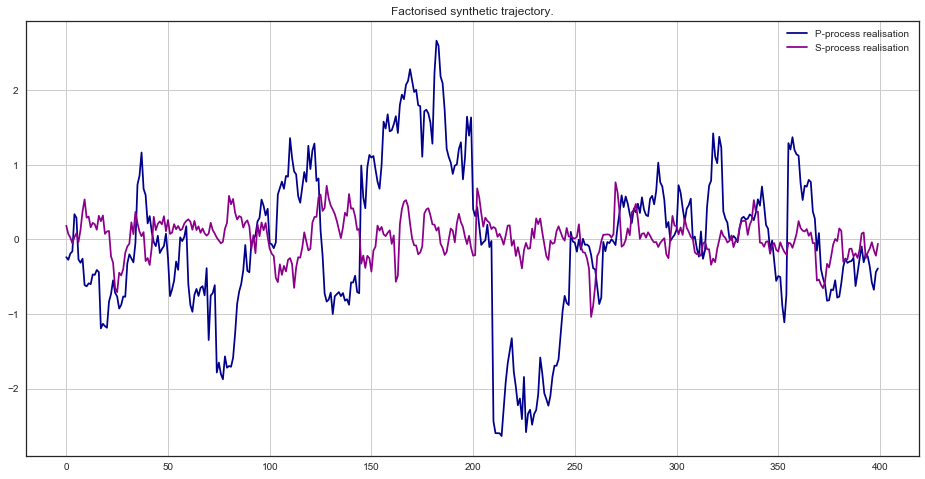

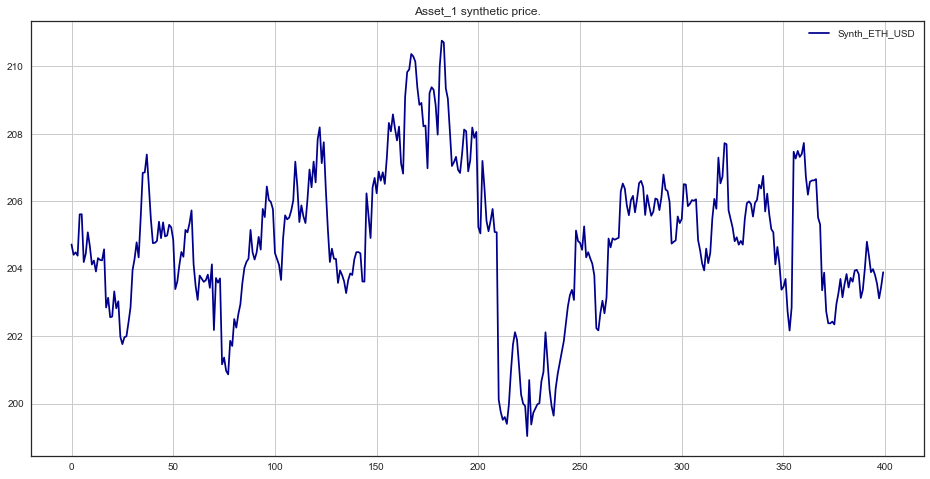

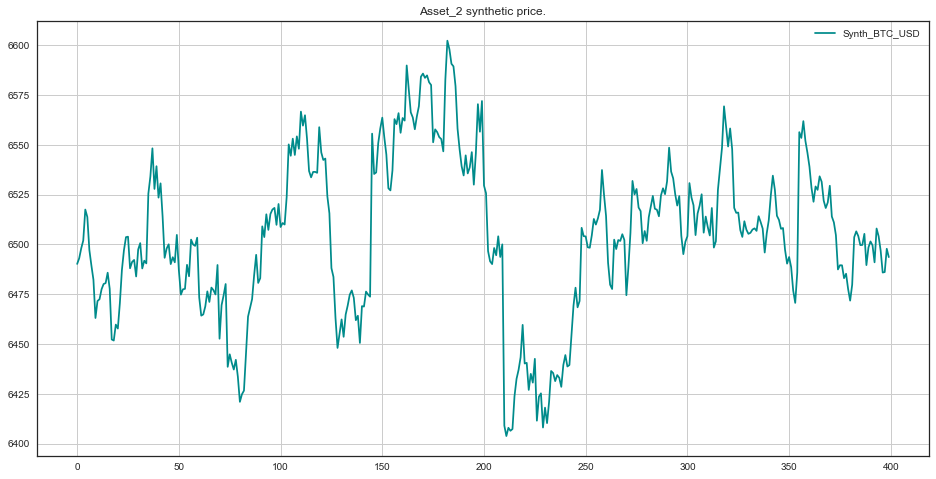

In [77]:
# Choose any point of trajectory,
# use built-in method to generate data: 
z = state_trajectory[-10]
factorized, reconstructed = model.generate(batch_size=1, size=400, state=z)

fig = plt.figure(num=4, figsize=(16, 8))
plt.title('Factorised synthetic trajectory.')
_ = plt.plot(factorized[0,0,:], color='darkblue', label='P-process realisation')
_ = plt.plot(factorized[0,1,:],  color='darkmagenta', label='S-process realisation')
_ = plt.legend()
plt.grid(True)

fig = plt.figure(num=5, figsize=(16, 8))
plt.title('Asset_1 synthetic price.')
_ = plt.plot(reconstructed[0,0,:], color='darkblue', label='Synth_ETH_USD')
_ = plt.legend()
plt.grid(True)

fig = plt.figure(num=6, figsize=(16, 8))
plt.title('Asset_2 synthetic price.')
_ = plt.plot(reconstructed[0,1,:],  color='darkcyan', label='Synth_BTC_USD')
_ = plt.legend()
plt.grid(True)

### 7 Generating from arbitrary sampled random state.
Model provides class method to generate random samples with arbitrary choosen state parameters.

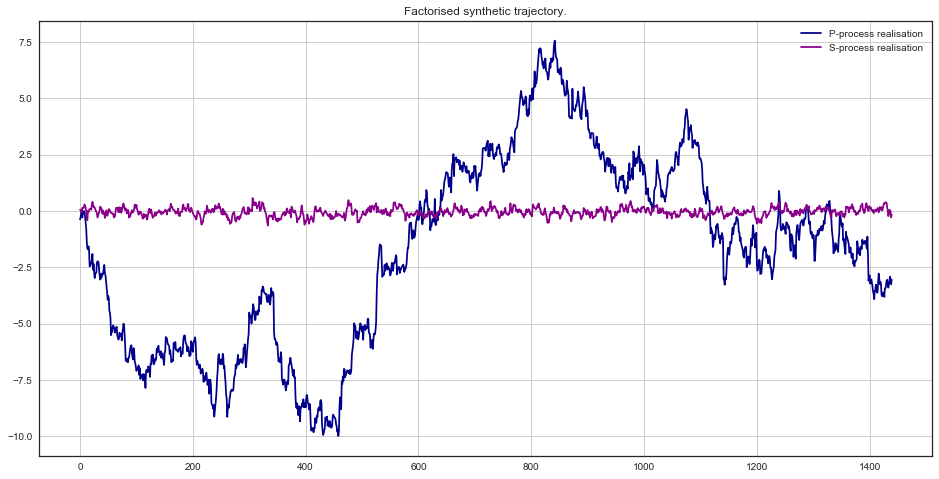

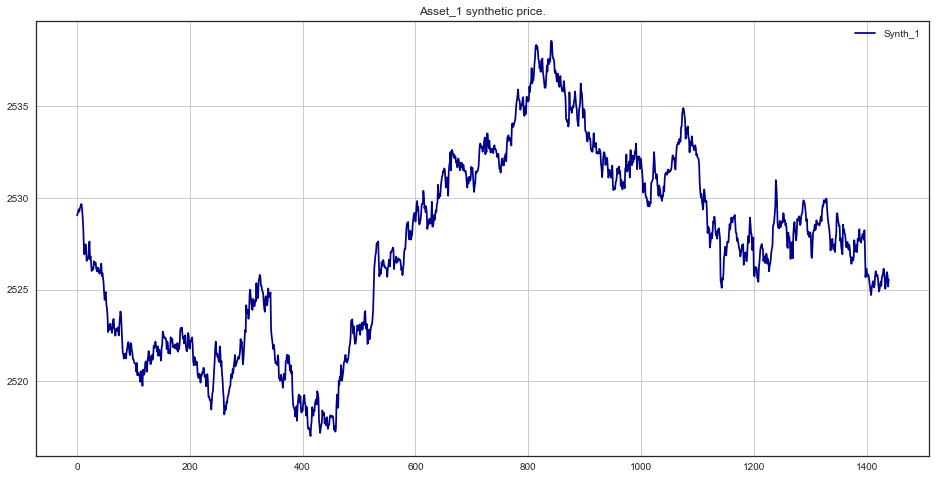

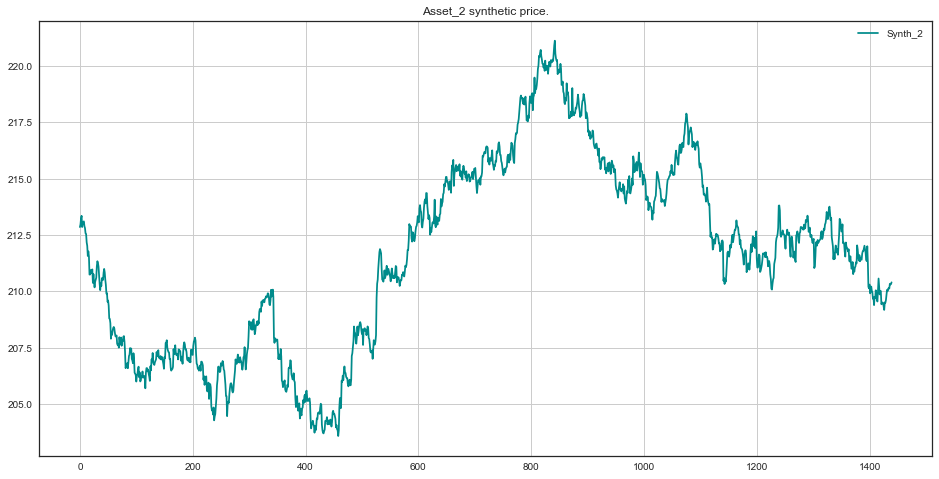

In [40]:
# Choose parameters intervals to draw uniform samples from:
p_params = dict(
    mu=[0, 0],
    theta=[.001, .008],
    sigma=[.1, .5],
    driver_df=[4, 5],
    variance=1e-2
)
s_params = dict(
    mu=[0, 0],
    theta=[.19, .2],
    sigma=[.1, .4],
    driver_df=[3, 15],
    variance=1e-2
)

# Get sample
z_sample = model.get_random_state(
    p_params, 
    s_params, 
    mean=(200, 3000), 
    variance=[1, 1.5], 
    ps_corrcoef=(.1, 1)
)

# Generate data:
factorized, reconstructed = model.generate(batch_size=1, size=1440, state=z_sample)

fig = plt.figure(num=7, figsize=(16, 8))
plt.title('Factorised synthetic trajectory.')
_ = plt.plot(factorized[0,0,:], color='darkblue', label='P-process realisation')
_ = plt.plot(factorized[0,1,:],  color='darkmagenta', label='S-process realisation')
_ = plt.legend()
plt.grid(True)

fig = plt.figure(num=8, figsize=(16, 8))
plt.title('Asset_1 synthetic price.')
_ = plt.plot(reconstructed[0,0,:], color='darkblue', label='Synth_1')
_ = plt.legend()
plt.grid(True)

fig = plt.figure(num=9, figsize=(16, 8))
plt.title('Asset_2 synthetic price.')
_ = plt.plot(reconstructed[0,1,:],  color='darkcyan', label='Synth_2')
_ = plt.legend()
plt.grid(True)